In [1]:
from IPython.core.display import HTML
HTML("""
<style>
.int {
    padding:10px 0px 0px 30px;
}
dd {
    margin: 0px 0px 15px 0px;
}
dt {
   color:blue;
}
</style>
""")

# Overview

# Background

## Definitions

<br/>
<dl>
    <dt>Charge (Q)</dt>
    <dd>The total charge in a battery available for driving a load. Charge is defined as<br/>
        <div class="int">
        $
        \begin{align}
            Q \triangleq\int_0^T i(t)\,dx
         \end{align}
        $
        </div>
        <br/>where <i>i</i> = discharge current and <i>T</i> = discharge time.
    <dt>Normalized Discharge Current (<i>i<sub>N</sub></i>)</dt>
    <dd>The ratio of discharge current to battery capacity, which we can express as
         <div class="int">
        $
        \begin{align}
            i_N\triangleq\frac{i}{Q}
         \end{align}
        $
        </div>
    <br/>where <i>i</i> = discharge current and <i>Q</i> = total battery charge.</dd>
    <dt>State of Charge (SOC)</dt>
    <dd>The percentage of total charge remaining in the battery.</dd>
 </dl>   

## Battery Discharge Basics

# Analysis 

In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from matplotlib.dates import HourLocator, MonthLocator, YearLocator
import seaborn as sns


In [3]:
iDischarge = 100
vTerm=4.10

       time   voltage
0  0.000000  4.100000
1  0.005556  4.038442
2  0.013921  4.024726
3  0.022296  4.018355
4  0.030671  4.013711
         time   voltage
523  4.373808  3.113157
524  4.382176  3.088299
525  4.390543  3.061071
526  4.398910  3.031350
527  4.407279  2.999140


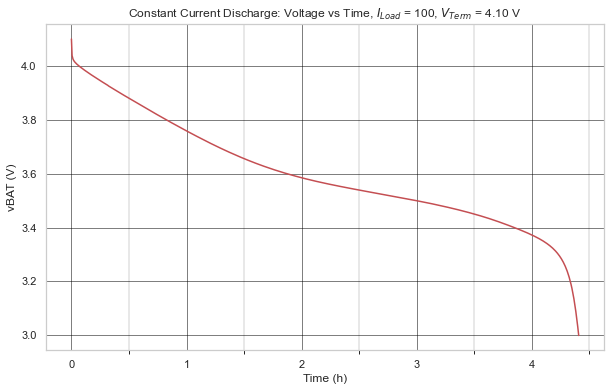

In [4]:
#  Import the CC Data
dfCC = pd.read_csv("CC_Portion_Discharge.csv")
dfCC['time'] = pd.to_datetime(dfCC['time'])  # Convert datestring string
minTime = dfCC["time"].min()+ datetime.timedelta(0,-20)
dfFirst = pd.DataFrame({'time':[minTime], 'voltage':[vTerm]})
dfCC = dfFirst.append(dfCC, ignore_index=True)
dfCC.time = dfCC.time-minTime     # Convert time to an interval
dfCC.time = dfCC.time/np.timedelta64(1, 'h') # Convert datetime to numerical hours
print(dfCC.head())
print(dfCC.tail())

# Graph the data
import matplotlib.ticker as mtick
from matplotlib.ticker import MultipleLocator
sns.set(font_scale=1.0, style="whitegrid")   # My standard for jupyter notebook plots
fig, ax = plt.subplots(figsize=(10,6))       # This is my standard size for jupyter notebooks
ax.plot(dfCC.time,dfCC.voltage, color='r',marker = '', linestyle ='-')
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.tick_params(axis='x', which='minor', bottom=True)
ax.tick_params(axis='y', which='minor', left=True)
ax.grid(b=True, which='minor', color='grey', linewidth=0.35)
ax.grid(b=True, which='major', color='black', linewidth=0.5)
ax.set_xlabel('Time (h)') 
ax.set_ylabel('vBAT (V)')
ax.set_title('Constant Current Discharge: Voltage vs Time, $I_{Load}$ = %i, $V_{Term}$ = %.2f V'%(iDischarge,vTerm))
plt.show()

***************** Discharge Metrics *****************
The discharge current is 100.00 mA
The discharge capacity is 440.71 mAh
The discharge time is 4.41 hours

***************** Dataframe Tail *****************
                  time   voltage       SOC
523           4.373808  3.113157  0.007544
524           4.382176  3.088299  0.005645
525           4.390543  3.061071  0.003747
526            4.39891  3.031350  0.001848
528  4.407055229525941  3.000000       0.0

***************** Dataframe Head *****************
       time   voltage       SOC
0       0.0  4.100000       1.0
1  0.005556  4.038442  0.998739
2  0.013921  4.024726  0.996841
3  0.022296  4.018355  0.994941
4  0.030671  4.013711   0.99304


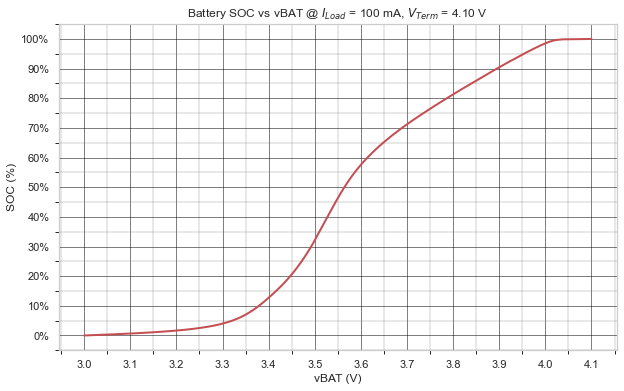

In [5]:
from scipy.interpolate import interp1d
from scipy.interpolate import InterpolatedUnivariateSpline
#print(dfCC.tail())

# Charge transferred during the CC phase

interpolate_x = 3.0                                # Find the time value when the battery is fully discharged
y_interp = interp1d(dfCC['voltage'], dfCC['time']) # Create interpolation object
tCritical =y_interp(interpolate_x)
Q_CC = tCritical*iDischarge          # Charge transferred will be normalized to this value
zz = pd.DataFrame({'time':[tCritical],'voltage':[3.0]})
dfCC1 = dfCC.append(zz,ignore_index=True)
dfCC1 = dfCC1[dfCC1['voltage']>=interpolate_x]
dfCC1['SOC'] = 1-iDischarge*dfCC1['time']/Q_CC
# Print out some data 
print(f'***************** Discharge Metrics *****************')
print(f'The discharge current is {iDischarge:.2f} mA')
print(f'The discharge capacity is {Q_CC:.2f} mAh')
print(f'The discharge time is {tCritical:.2f} hours\n')
print(f'***************** Dataframe Tail *****************')      
print(dfCC1.tail())
print(f'\n***************** Dataframe Head *****************')      
print(dfCC1.head())

# Plot the SOC

sns.set(font_scale=1.0, style="whitegrid")   # My standard for jupyter notebook plots
fig, ax = plt.subplots(figsize=(10,6))       # This is my standard size for jupyter notebooks
ax.plot(dfCC1['voltage'],dfCC1['SOC']*100, color='r',marker = '', linestyle ='-',linewidth=2)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.tick_params(axis='x', which='minor', bottom=True)
ax.tick_params(axis='y', which='minor', left=True)
ax.grid(b=True, which='minor', color='grey', linewidth=0.35)
ax.grid(b=True, which='major', color='black', linewidth=0.5)
ax.set_xlabel('vBAT (V)') 
ax.set_ylabel('SOC (%)')
ax.set_title('Battery SOC vs vBAT @ $I_{Load}$ = %i mA, $V_{Term}$ = %.2f V'%(iDischarge,vTerm))
plt.show()


In [6]:
from scipy import interpolate
y = np.linspace(0, 100, num=101, endpoint=True)/100
iObject = interpolate.interp1d(dfCC1.SOC,dfCC1.voltage)
SOCnew = iObject(y)
lookup = pd.DataFrame({'SOC':y*100, 'voltage':SOCnew})
lookup.head()
lookup.tail()
lookup.to_csv('SOC_4_10.csv', index=False)